In [1]:
import sys
import os
from itertools import product
import math
import numpy
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from scipy.cluster.hierarchy import dendrogram, leaves_list
from scipy.spatial.distance import pdist
from sklearn.manifold import TSNE, MDS
# import umap
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time

sys.path.append(os.path.abspath("../sim_metric/dists"))
from scoring import *

# Load distances and representations

In [2]:
pretrained = True
folder = "distances/train/untrained"
if pretrained:
    folder = "distances/train/pretrained"

In [3]:
# Load the ImageNet distances between train datasets
filenames = os.listdir(folder)
distnames = []
for filename in filenames:
    if filename.endswith("npy"):
        distnames.append(filename[:-4])
distnames = np.sort(distnames)

In [4]:
print(distnames)

['lin_cka_dist' 'lin_cka_prime_dist' 'mean_cca_e2e' 'mean_sq_cca_e2e'
 'predictor_dist_0.0' 'predictor_dist_0.0001' 'predictor_dist_0.001'
 'predictor_dist_0.01' 'predictor_dist_0.1' 'predictor_dist_1.0'
 'predictor_dist_10.0' 'predictor_dist_100.0' 'predictor_dist_1000.0'
 'predictor_dist_10000.0' 'predictor_dist_1e-05' 'predictor_dist_1e-06'
 'predictor_dist_1e-07' 'predictor_dist_1e-08' 'predictor_dist_1e-09'
 'predictor_dist_1e-10' 'predictor_dist_1e-11' 'predictor_dist_1e-12'
 'predictor_dist_1e-13' 'predictor_dist_1e-14' 'predictor_dist_1e-15'
 'predictor_dist_1e-16' 'predictor_dist_1e-17' 'predictor_dist_1e-18'
 'predictor_dist_1e-19' 'predictor_dist_1e-20' 'procrustes'
 'pwcca_dist_e2e']


In [5]:
stats = np.load(f"{folder}/stats.npz")
model_names = stats["model_names"]
total_models = len(model_names)
dist_pairs_saved = stats["dist_pairs_saved"]

In [6]:
# Check all distance pairs are saved. The output should be all-zeros
print(np.arange(total_models) - np.sum(dist_pairs_saved, axis=0))
print(np.arange(total_models) - np.flip(np.sum(dist_pairs_saved, axis=1)))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]


In [7]:
print(model_names)

['alexnet_pretrained_rep' 'convnext_base_pretrained_rep'
 'convnext_large_pretrained_rep' 'convnext_small_pretrained_rep'
 'convnext_tiny_pretrained_rep' 'densenet_pretrained_rep'
 'efficientnet_b0_pretrained_rep' 'efficientnet_b1_pretrained_rep'
 'efficientnet_b2_pretrained_rep' 'efficientnet_b3_pretrained_rep'
 'efficientnet_b4_pretrained_rep' 'efficientnet_b5_pretrained_rep'
 'efficientnet_b6_pretrained_rep' 'efficientnet_b7_pretrained_rep'
 'googlenet_pretrained_rep' 'inception_pretrained_rep'
 'mnasnet_pretrained_rep' 'mobilenet_v2_pretrained_rep'
 'mobilenet_v3_large_pretrained_rep' 'mobilenet_v3_small_pretrained_rep'
 'regnet_x_16gf_pretrained_rep' 'regnet_x_1_6gf_pretrained_rep'
 'regnet_x_32gf_pretrained_rep' 'regnet_x_3_2gf_pretrained_rep'
 'regnet_x_400mf_pretrained_rep' 'regnet_x_800mf_pretrained_rep'
 'regnet_x_8gf_pretrained_rep' 'regnet_y_16gf_pretrained_rep'
 'regnet_y_1_6gf_pretrained_rep' 'regnet_y_32gf_pretrained_rep'
 'regnet_y_3_2gf_pretrained_rep' 'regnet_y_400mf_

In [8]:
distances = {}
def symmetrize(A):
    n = A.shape[0]
    B = A.copy()
    B[np.tril_indices(n)] = B.T[np.tril_indices(n)]
    return B
for distname in distnames:
    print(distname)
    curr_dist = np.load(f"{folder}/{distname}.npy")  
    distances[distname] = symmetrize(curr_dist)
#     print(distances[distname])

lin_cka_dist
lin_cka_prime_dist
mean_cca_e2e
mean_sq_cca_e2e
predictor_dist_0.0
predictor_dist_0.0001
predictor_dist_0.001
predictor_dist_0.01
predictor_dist_0.1
predictor_dist_1.0
predictor_dist_10.0
predictor_dist_100.0
predictor_dist_1000.0
predictor_dist_10000.0
predictor_dist_1e-05
predictor_dist_1e-06
predictor_dist_1e-07
predictor_dist_1e-08
predictor_dist_1e-09
predictor_dist_1e-10
predictor_dist_1e-11
predictor_dist_1e-12
predictor_dist_1e-13
predictor_dist_1e-14
predictor_dist_1e-15
predictor_dist_1e-16
predictor_dist_1e-17
predictor_dist_1e-18
predictor_dist_1e-19
predictor_dist_1e-20
procrustes
pwcca_dist_e2e


In [9]:
if pretrained:
    train_reps_folder = 'reps/train/10000_eval/'
    val_reps_folder = 'reps/val/3000_eval/'
else:
    assert(False)

# Load ImageNet representations
reps_train = {}
reps_val = {}
for model_name in model_names:
    print(model_name)
    rep1 = np.load(train_reps_folder + model_name + ".npy")
    # center and normalize
    rep1 = rep1 - rep1.mean(axis=1, keepdims=True)
    rep1 = rep1 / np.linalg.norm(rep1)
    rep1 = rep1 * np.sqrt(rep1.shape[1])
    reps_train[model_name] = rep1
    
    rep2 = np.load(val_reps_folder + model_name + ".npy")
    # center and normalize
    rep2 = rep2 - rep2.mean(axis=1, keepdims=True)
    rep2 = rep2 / np.linalg.norm(rep2)
    rep2 = rep2 * np.sqrt(rep2.shape[1])
    reps_val[model_name] = rep2

alexnet_pretrained_rep
convnext_base_pretrained_rep
convnext_large_pretrained_rep
convnext_small_pretrained_rep
convnext_tiny_pretrained_rep
densenet_pretrained_rep
efficientnet_b0_pretrained_rep
efficientnet_b1_pretrained_rep
efficientnet_b2_pretrained_rep
efficientnet_b3_pretrained_rep
efficientnet_b4_pretrained_rep
efficientnet_b5_pretrained_rep
efficientnet_b6_pretrained_rep
efficientnet_b7_pretrained_rep
googlenet_pretrained_rep
inception_pretrained_rep
mnasnet_pretrained_rep
mobilenet_v2_pretrained_rep
mobilenet_v3_large_pretrained_rep
mobilenet_v3_small_pretrained_rep
regnet_x_16gf_pretrained_rep
regnet_x_1_6gf_pretrained_rep
regnet_x_32gf_pretrained_rep
regnet_x_3_2gf_pretrained_rep
regnet_x_400mf_pretrained_rep
regnet_x_800mf_pretrained_rep
regnet_x_8gf_pretrained_rep
regnet_y_16gf_pretrained_rep
regnet_y_1_6gf_pretrained_rep
regnet_y_32gf_pretrained_rep
regnet_y_3_2gf_pretrained_rep
regnet_y_400mf_pretrained_rep
regnet_y_800mf_pretrained_rep
regnet_y_8gf_pretrained_rep
resnet

# Predict generalization, random y's

In [10]:
def find_best_pred(y, lmbda, reps):
    # ridge regression 
    # assume reps is dimension x number datapoints 
    rep_dim = reps.shape[0]
    numpts = reps.shape[1]
    
    return np.linalg.solve((lmbda*np.eye(rep_dim) + (reps @ reps.T) / numpts), reps@y)
    

In [11]:
import scipy.stats

In [ ]:
collected_correlations = []

numtrials = 50

labels = []
for ky,val in distances.items():
    if ky != 'predictor_dist_range':
        labels.append(ky)
print(labels)

def flatten_upper_right_triangle(curr_mat):
    cv = []
    assert(curr_mat.shape[0] == curr_mat.shape[1])
    assert(curr_mat.shape[0] == len(model_names))
    for i in range(len(model_names)-1):
        for j in range(i+1,len(model_names)):
            cv.append(curr_mat[i,j])
    cv = np.asarray(cv)
    return cv

dist_vecs = {}

for distname in labels:
    dist_vecs[distname] = flatten_upper_right_triangle(distances[distname])

for tri in range(numtrials):
    print(f'Trial {tri}')

    y = np.random.randn(10000,1) + 1

    preds = {}
#     lmbda = 0.1 #1e-5
#     lmbda = 1e-7
    lmbda = 0.01
    for model_name in model_names:
#         print(model_name)
        preds[model_name] = find_best_pred(y, lmbda, reps_train[model_name])

#     # For each pair, compute the squared distance between predictions, averaged over test instances 

    errs = np.zeros((len(model_names), len(model_names)))
    for ind1 in range(0, len(model_names)-1):
        for ind2 in range(ind1+1, len(model_names)):
            cp1 = preds[model_names[ind1]].T @ reps_val[model_names[ind1]]
            cp2 = preds[model_names[ind2]].T @ reps_val[model_names[ind2]]
#             print(cp1.shape)
            errs[ind1, ind2] = np.linalg.norm(cp1 - cp2)
            errs[ind2, ind1] = errs[ind1, ind2]
    err_vec = flatten_upper_right_triangle(errs)
    
    correlations = []

    for distname in labels:
        val = scipy.stats.spearmanr(err_vec, dist_vecs[distname]).correlation
        correlations.append(val)
        
    collected_correlations.append(correlations)

['lin_cka_dist', 'lin_cka_prime_dist', 'mean_cca_e2e', 'mean_sq_cca_e2e', 'predictor_dist_0.0', 'predictor_dist_0.0001', 'predictor_dist_0.001', 'predictor_dist_0.01', 'predictor_dist_0.1', 'predictor_dist_1.0', 'predictor_dist_10.0', 'predictor_dist_100.0', 'predictor_dist_1000.0', 'predictor_dist_10000.0', 'predictor_dist_1e-05', 'predictor_dist_1e-06', 'predictor_dist_1e-07', 'predictor_dist_1e-08', 'predictor_dist_1e-09', 'predictor_dist_1e-10', 'predictor_dist_1e-11', 'predictor_dist_1e-12', 'predictor_dist_1e-13', 'predictor_dist_1e-14', 'predictor_dist_1e-15', 'predictor_dist_1e-16', 'predictor_dist_1e-17', 'predictor_dist_1e-18', 'predictor_dist_1e-19', 'predictor_dist_1e-20', 'procrustes', 'pwcca_dist_e2e']
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6


In [ ]:
std_devs = []
means = []
for i in range(len(collected_correlations[0])):
    cvs = [collected_correlations[j][i] for j in range(len(collected_correlations))]
    std_devs.append(scipy.stats.sem(cvs))
    means.append(np.mean(cvs))
std_devs = np.array(std_devs)
means = np.array(means)
print(std_devs)

In [ ]:
print(labels)

In [ ]:
subset_labels = ['lin_cka_dist', 'mean_sq_cca_e2e', 'pwcca_dist_e2e', 'procrustes', 'predictor_dist_0.0', 'predictor_dist_1e-07', 'predictor_dist_1e-06', 'predictor_dist_1e-05', 'predictor_dist_0.0001', 'predictor_dist_0.001', 'predictor_dist_0.01', 'predictor_dist_0.1', 'predictor_dist_1.0', 'predictor_dist_10.0']
subset_indices = []
for i in range(len(subset_labels)):
    subset_indices.append(labels.index(subset_labels[i]))
#     print(subset_indices)
lbels = labels
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(range(len(subset_labels)),means[subset_indices], yerr = std_devs[subset_indices])
plt.xticks(range(len(subset_labels)), labels=subset_labels, rotation='vertical')
plt.ylim(0,1)
plt.title('total average correlation')
plt.show()

# Predict generalization

In [10]:
def find_best_pred(y, lmbda, reps):
    # ridge regression 
    # assume reps is dimension x number datapoints 
    rep_dim = reps.shape[0]
    numpts = reps.shape[1]
    
    return np.linalg.solve((lmbda*np.eye(rep_dim) + (reps @ reps.T)), reps@y)
    

In [11]:
import scipy.stats

Basing ground truth off of alexnet_pretrained_rep
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


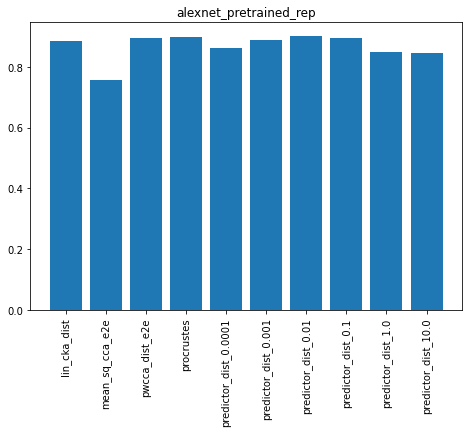

Basing ground truth off of convnext_base_pretrained_rep
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


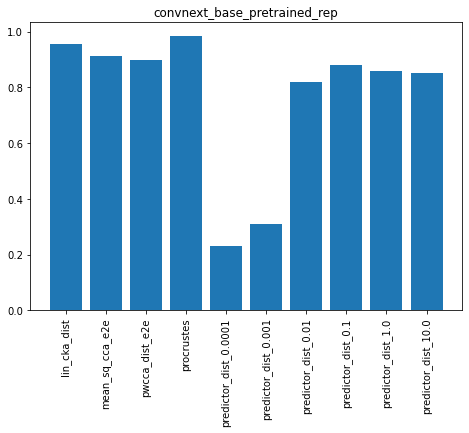

Basing ground truth off of convnext_large_pretrained_rep
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


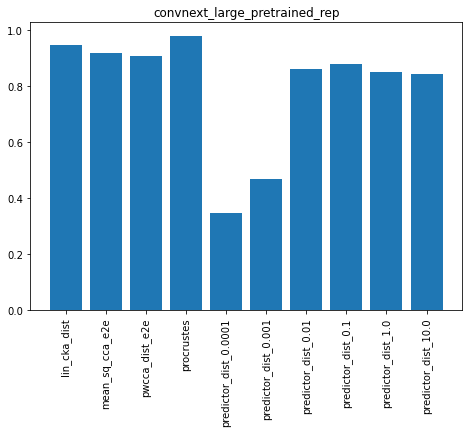

Basing ground truth off of convnext_small_pretrained_rep
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


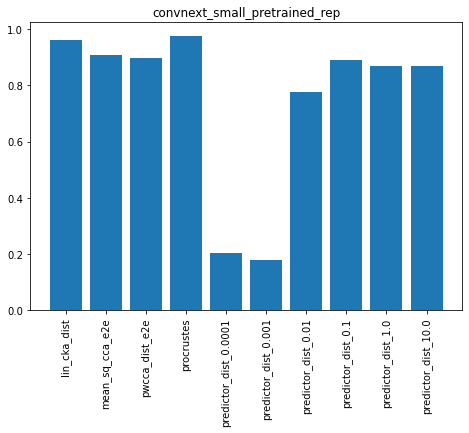

Basing ground truth off of convnext_tiny_pretrained_rep
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


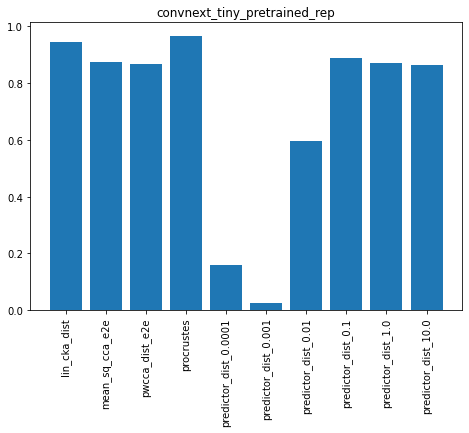

Basing ground truth off of densenet_pretrained_rep
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


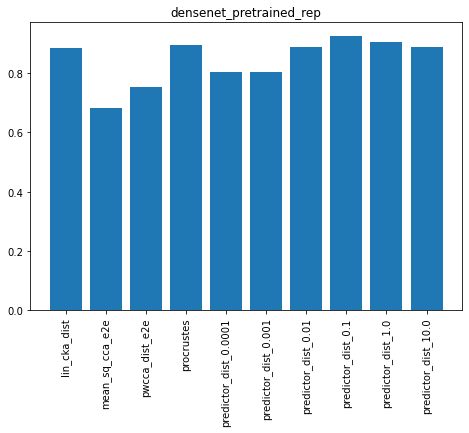

Basing ground truth off of efficientnet_b0_pretrained_rep
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


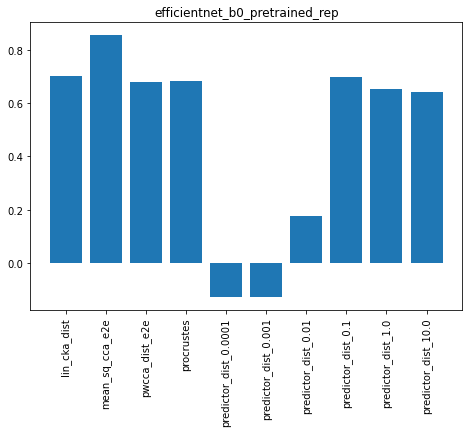

Basing ground truth off of efficientnet_b1_pretrained_rep
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


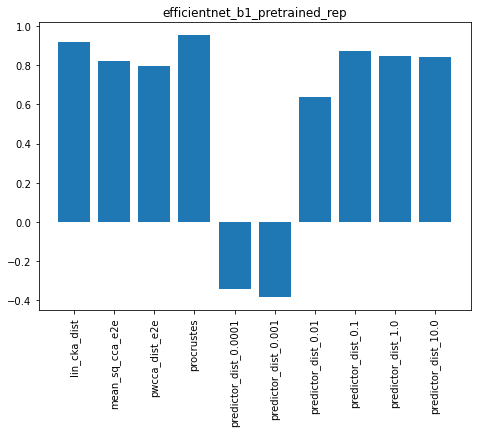

Basing ground truth off of efficientnet_b2_pretrained_rep
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


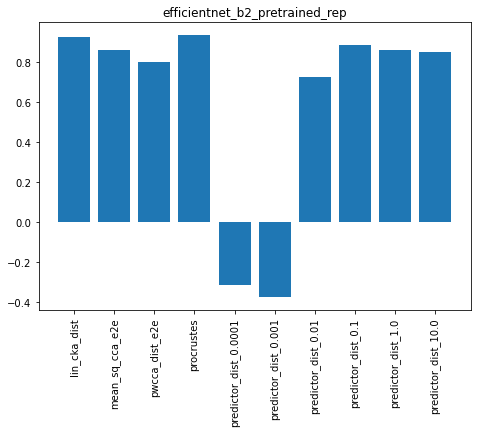

Basing ground truth off of efficientnet_b3_pretrained_rep
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


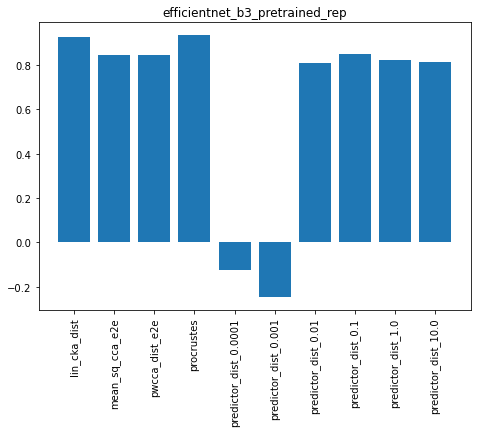

Basing ground truth off of efficientnet_b4_pretrained_rep
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


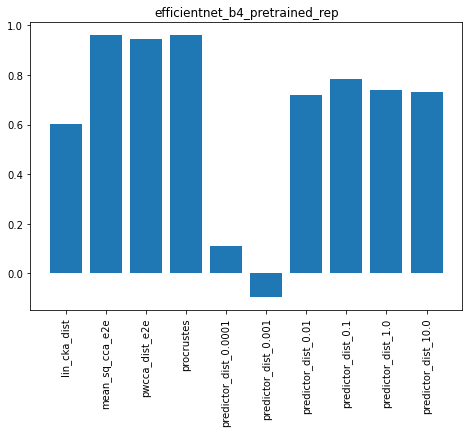

Basing ground truth off of efficientnet_b5_pretrained_rep
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


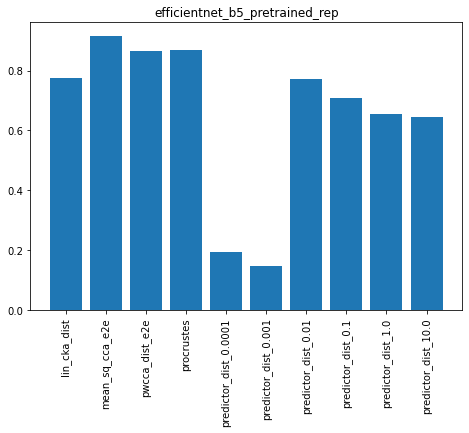

Basing ground truth off of efficientnet_b6_pretrained_rep
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


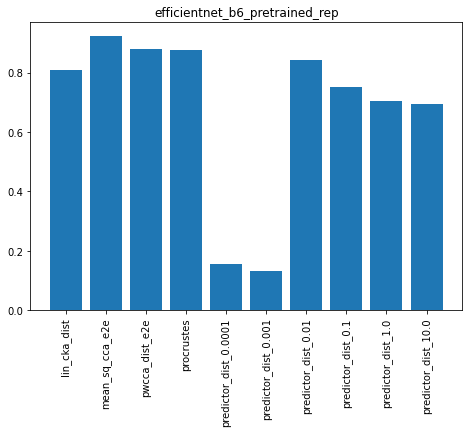

Basing ground truth off of efficientnet_b7_pretrained_rep
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


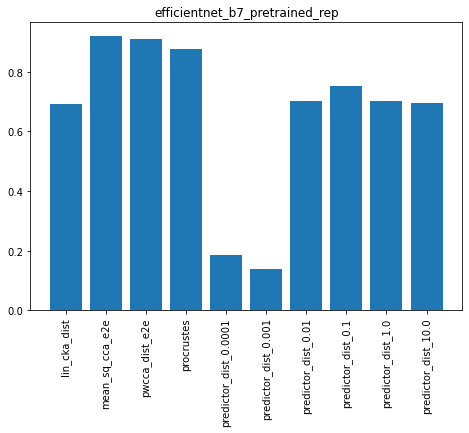

Basing ground truth off of googlenet_pretrained_rep
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


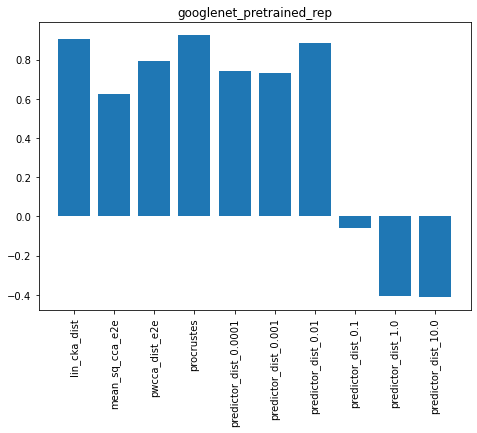

Basing ground truth off of inception_pretrained_rep
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


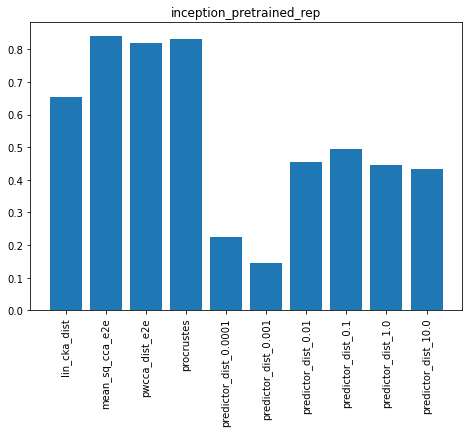

Basing ground truth off of mnasnet_pretrained_rep
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


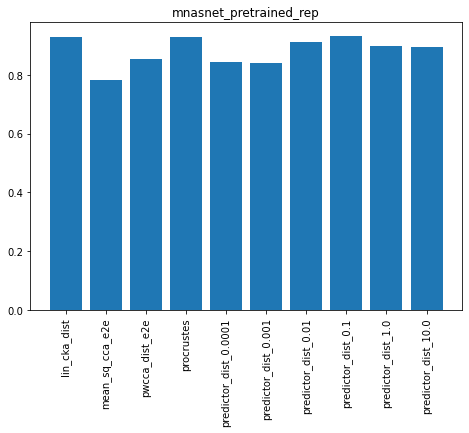

Basing ground truth off of mobilenet_v2_pretrained_rep
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


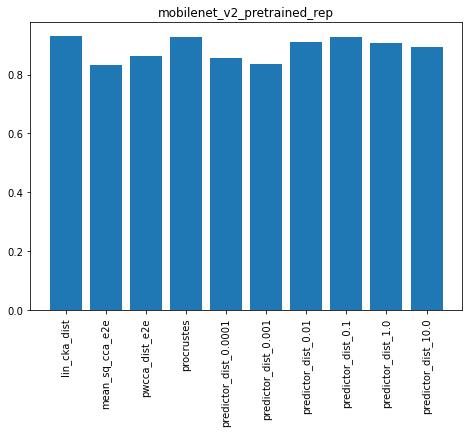

Basing ground truth off of mobilenet_v3_large_pretrained_rep
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


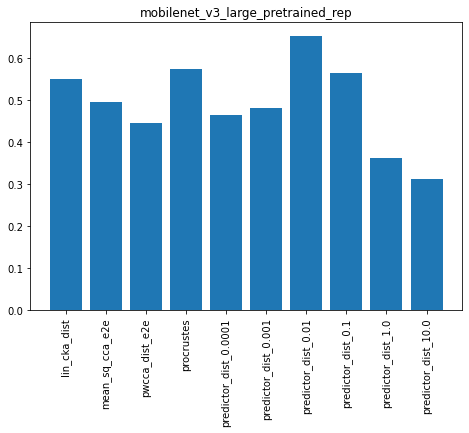

Basing ground truth off of mobilenet_v3_small_pretrained_rep
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


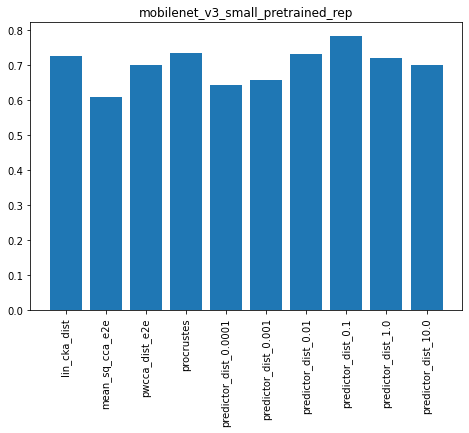

Basing ground truth off of regnet_x_16gf_pretrained_rep
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


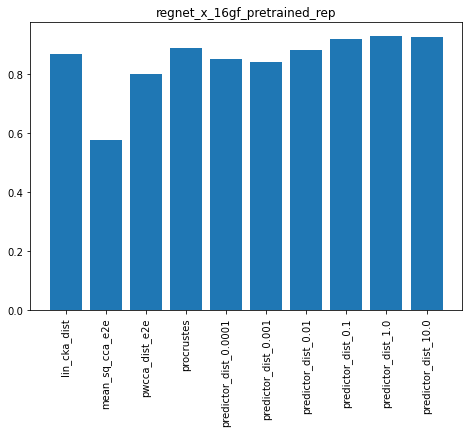

Basing ground truth off of regnet_x_1_6gf_pretrained_rep
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


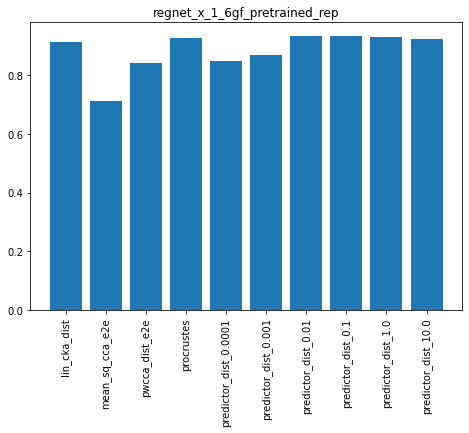

Basing ground truth off of regnet_x_32gf_pretrained_rep
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


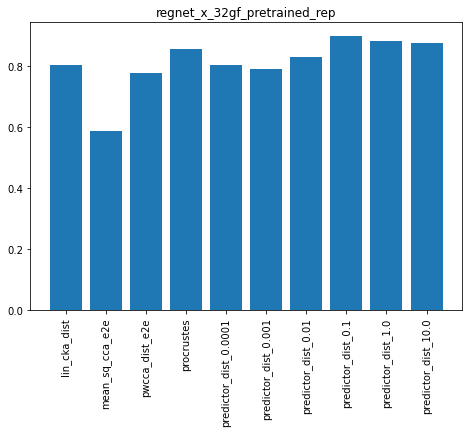

Basing ground truth off of regnet_x_3_2gf_pretrained_rep
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


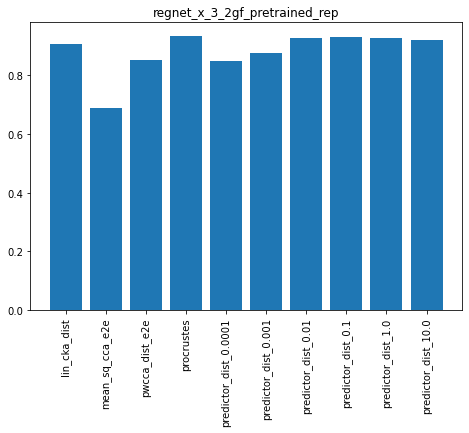

Basing ground truth off of regnet_x_400mf_pretrained_rep
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


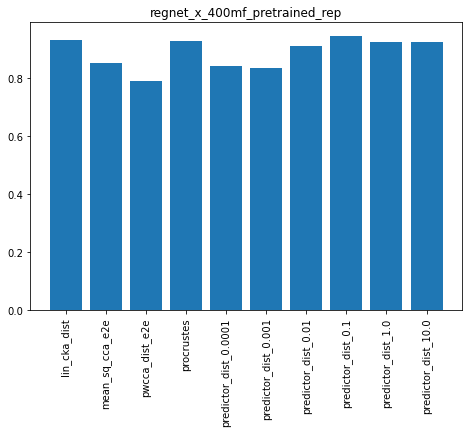

Basing ground truth off of regnet_x_800mf_pretrained_rep
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


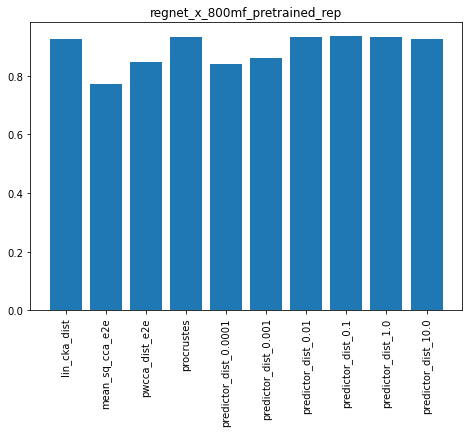

Basing ground truth off of regnet_x_8gf_pretrained_rep
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


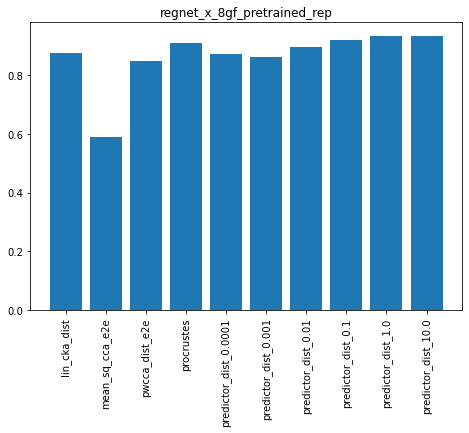

Basing ground truth off of regnet_y_16gf_pretrained_rep
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


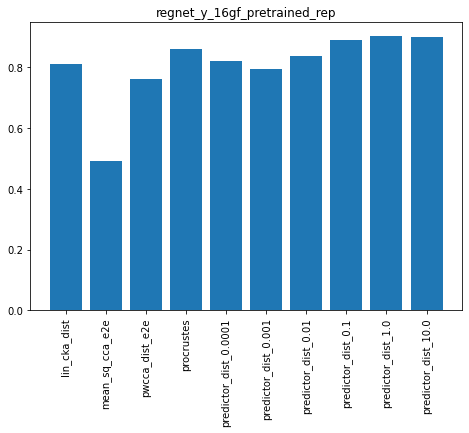

Basing ground truth off of regnet_y_1_6gf_pretrained_rep
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


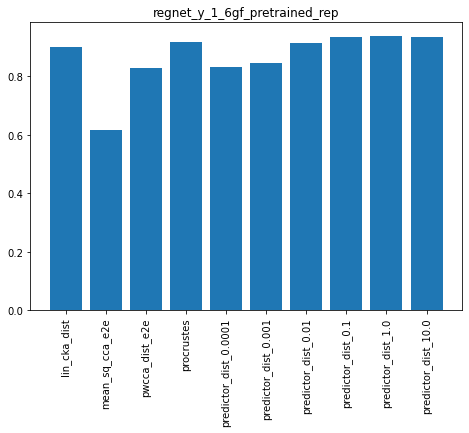

Basing ground truth off of regnet_y_32gf_pretrained_rep
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


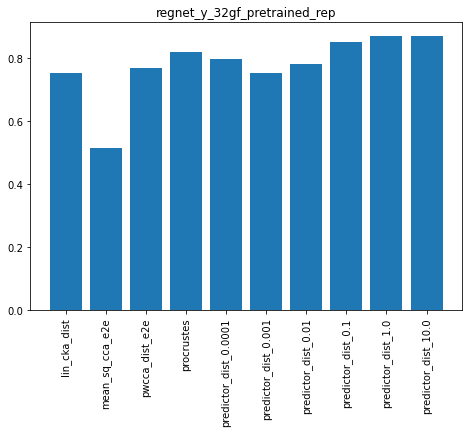

Basing ground truth off of regnet_y_3_2gf_pretrained_rep
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


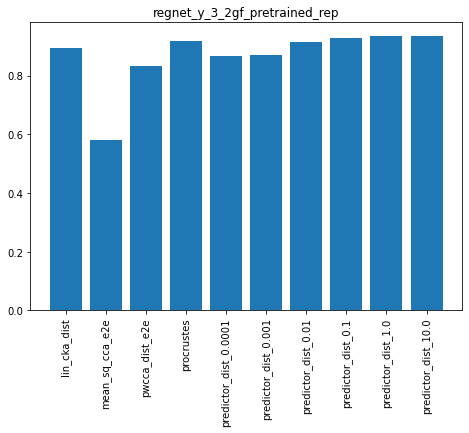

Basing ground truth off of regnet_y_400mf_pretrained_rep
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


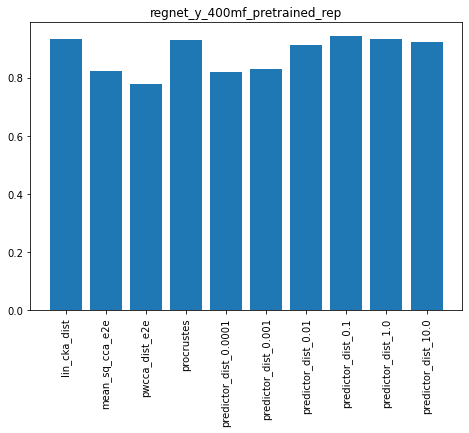

Basing ground truth off of regnet_y_800mf_pretrained_rep
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


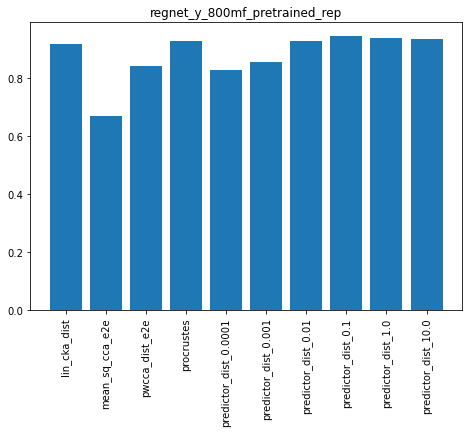

Basing ground truth off of regnet_y_8gf_pretrained_rep
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


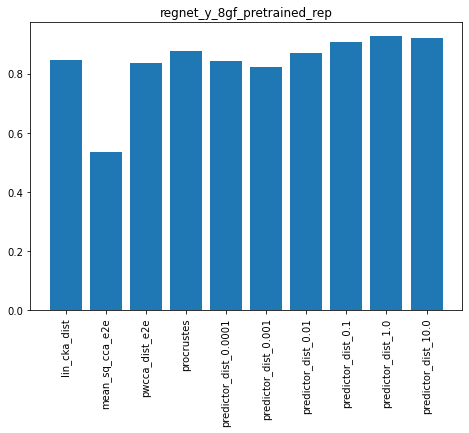

Basing ground truth off of resnet18_pretrained_rep
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


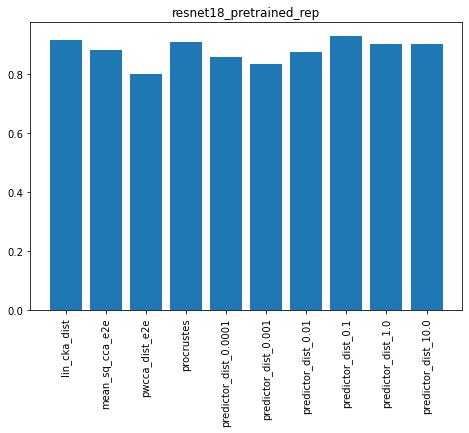

Basing ground truth off of resnext50_32x4d_pretrained_rep
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


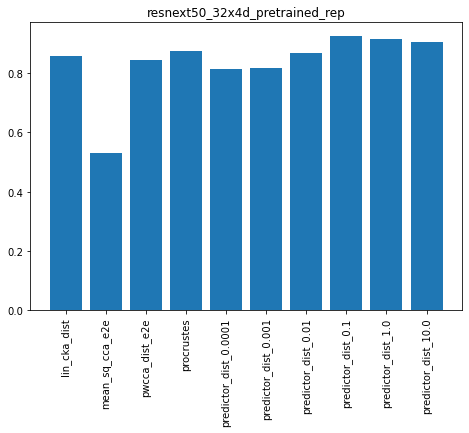

Basing ground truth off of shufflenet_pretrained_rep
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


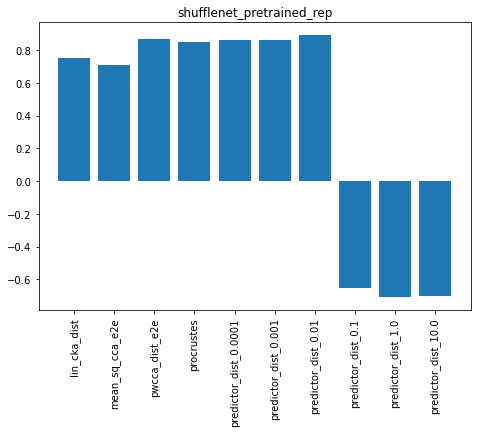

Basing ground truth off of squeezenet_pretrained_rep
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


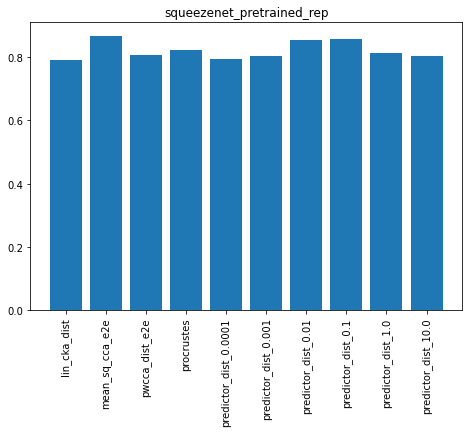

Basing ground truth off of vgg16_pretrained_rep
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


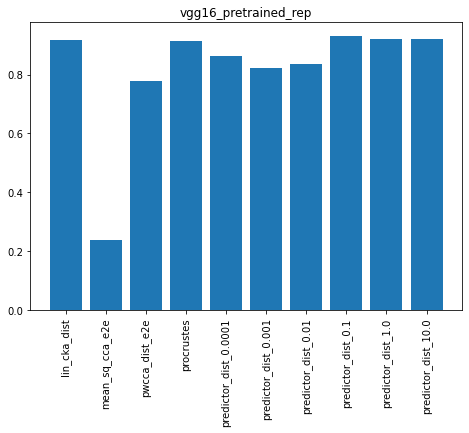

Basing ground truth off of vit_b_16_pretrained_rep
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


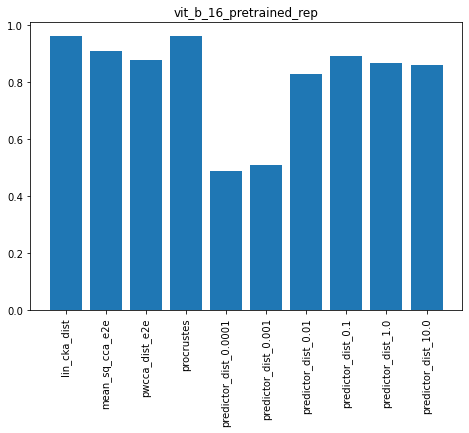

Basing ground truth off of vit_b_32_pretrained_rep
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


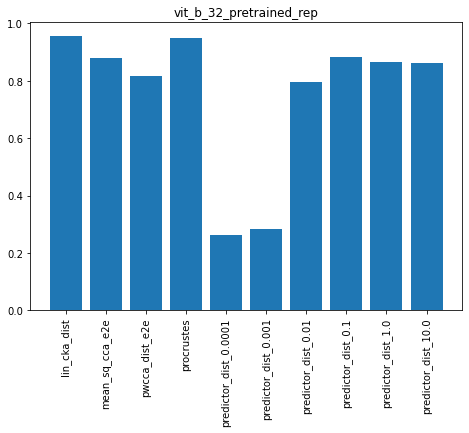

Basing ground truth off of vit_l_16_pretrained_rep
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


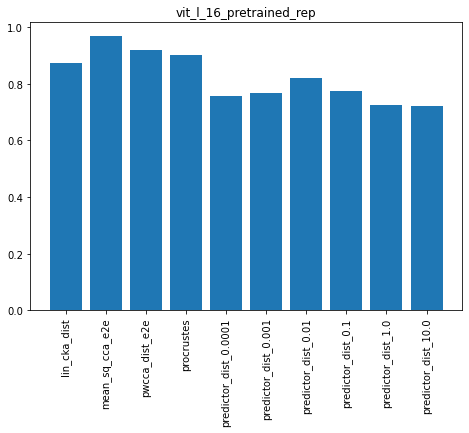

Basing ground truth off of vit_l_32_pretrained_rep
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


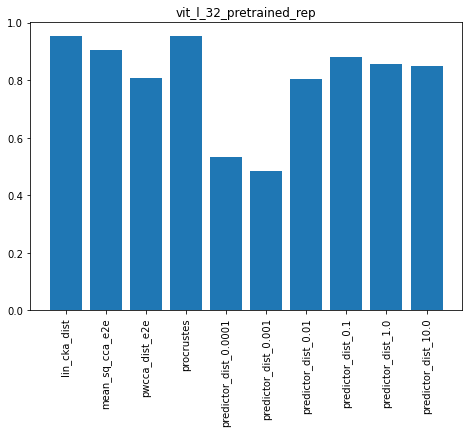

Basing ground truth off of wide_resnet50_2_pretrained_rep
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


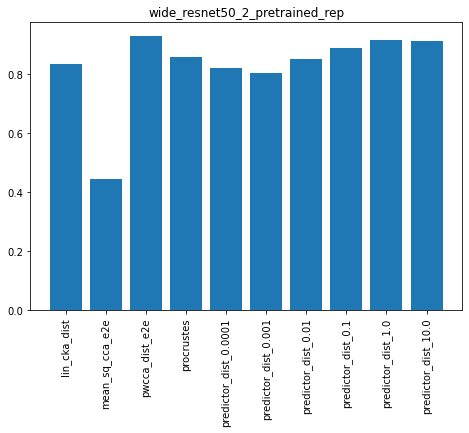

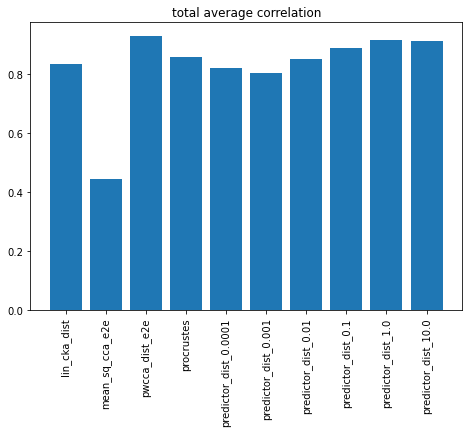

In [38]:
collected_correlations = []

model_inds = range(0,len(model_names))
# model_inds = [0, 1]
for base_ind in model_inds:
    base_model_ind = base_ind
    numtrials = 10

    base_model = model_names[base_model_ind]
    print(f'Basing ground truth off of {base_model}')

    all_correlations = []
    all_errs = []
    for tri in range(numtrials):
        print(f'Trial {tri}')

        beta = np.random.rand(1, reps_train[base_model].shape[0])
        y = (beta@reps_train[base_model]).T
    #     print('y',y)


        preds = {}
    #     lmbda = 0.1 #1e-5
    #     lmbda = 1e-7
        lmbda = 1e-2
        for model_name in model_names:
    #         print(model_name)
            preds[model_name] = find_best_pred(y, lmbda, reps_train[model_name])

        # For each pair, compute the squared distance between predictions, averaged over test instances 

        errs = np.zeros((len(model_names), len(model_names)))
        for ind1 in range(0, len(model_names)-1):
            for ind2 in range(ind1+1, len(model_names)):
                cp1 = preds[model_names[ind1]].T @ reps_val[model_names[ind1]]
                cp2 = preds[model_names[ind2]].T @ reps_val[model_names[ind2]]
    #             print(cp1.shape)
                errs[ind1, ind2] = np.linalg.norm(cp1 - cp2)
                errs[ind2, ind1] = errs[ind1, ind2]
        all_errs.append(errs)

        # gather the precomputed distances for comparison
        labels = []
        correlations = []
        for ky,val in distances.items():
            if ky != 'predictor_dist_range':
                labels.append(ky)
                dist_vec = []
                err_vec = []
                for i in range(len(model_names)):
                    if i == base_model_ind:
                        continue
                    dist_vec.append(distances[ky][base_model_ind][i])
                    err_vec.append(errs[base_model_ind,i])

                val = scipy.stats.spearmanr(err_vec, dist_vec).correlation
                correlations.append(val)
        collected_correlations.append(np.array(correlations))
        if tri == 0:
            avg_correlations = np.array(correlations)
        else:
            avg_correlations = avg_correlations + np.array(correlations)
        all_correlations.append(correlations)

    avg_correlations = avg_correlations / numtrials
    
    subset_labels = ['lin_cka_dist', 'mean_sq_cca_e2e', 'pwcca_dist_e2e', 'procrustes', 'predictor_dist_0.0001', 'predictor_dist_0.001', 'predictor_dist_0.01', 'predictor_dist_0.1', 'predictor_dist_1.0', 'predictor_dist_10.0']
    subset_indices = []
    for i in range(len(subset_labels)):
        subset_indices.append(labels.index(subset_labels[i]))
    #     print(subset_indices)
    lbels = labels
    import matplotlib.pyplot as plt
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    # ax.bar(range(len(labels)),avg_correlations)
    ax.bar(range(len(subset_labels)),avg_correlations[subset_indices])
    #     print(subset_labels)
    plt.xticks(range(len(subset_labels)), labels=subset_labels, rotation='vertical')
    plt.title(model_names[base_ind])
    plt.show()
    
    if tot_avg_correlations is None:
        tot_avg_correlations = np.array(avg_correlations)
    else:
        tot_avg_correlations = tot_avg_correlations + avg_correlations
        
tot_avg_correlations = tot_avg_correlations / len(model_inds)
    

subset_labels = ['lin_cka_dist', 'mean_sq_cca_e2e', 'pwcca_dist_e2e', 'procrustes', 'predictor_dist_0.0001', 'predictor_dist_0.001', 'predictor_dist_0.01', 'predictor_dist_0.1', 'predictor_dist_1.0', 'predictor_dist_10.0']
subset_indices = []
for i in range(len(subset_labels)):
    subset_indices.append(labels.index(subset_labels[i]))
#     print(subset_indices)
lbels = labels
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
# ax.bar(range(len(labels)),avg_correlations)
ax.bar(range(len(subset_labels)),avg_correlations[subset_indices])
#     print(subset_labels)
plt.xticks(range(len(subset_labels)), labels=subset_labels, rotation='vertical')
plt.title('total average correlation')
plt.show()

In [39]:
std_devs = []
means = []
for i in range(len(collected_correlations[0])):
    cvs = [collected_correlations[j][i] for j in range(len(collected_correlations))]
    std_devs.append(scipy.stats.sem(cvs))
    means.append(np.mean(cvs))
std_devs = np.array(std_devs)
means = np.array(means)
print(std_devs)

[0.0049069  0.02132297 0.00959314 0.00820281 0.00819022 0.01731037
 0.01843503 0.00671175 0.01333383 0.01518444 0.01521395 0.01522757
 0.01523468 0.01523468 0.01456169 0.01014105 0.00510835 0.00424402
 0.00463728 0.00472253 0.0047127  0.00469854 0.00470669 0.00472095
 0.00472253 0.00474705 0.00562122 0.00781656 0.00815164 0.00819057
 0.00376496 0.00391225]


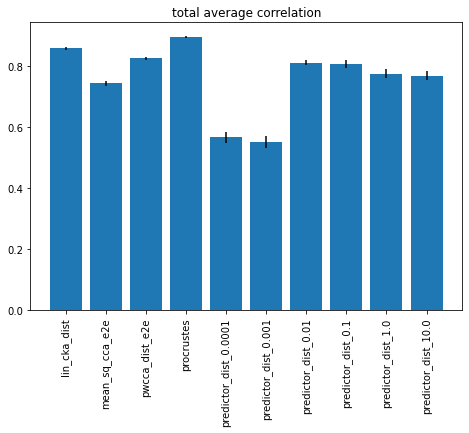

In [40]:
subset_labels = ['lin_cka_dist', 'mean_sq_cca_e2e', 'pwcca_dist_e2e', 'procrustes', 'predictor_dist_0.0001', 'predictor_dist_0.001', 'predictor_dist_0.01', 'predictor_dist_0.1', 'predictor_dist_1.0', 'predictor_dist_10.0']
subset_indices = []
for i in range(len(subset_labels)):
    subset_indices.append(labels.index(subset_labels[i]))
#     print(subset_indices)
lbels = labels
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
# ax.bar(range(len(labels)),avg_correlations)
ax.bar(range(len(subset_labels)),means[subset_indices], yerr = std_devs[subset_indices])
#     print(subset_labels)
plt.xticks(range(len(subset_labels)), labels=subset_labels, rotation='vertical')
plt.title('total average correlation')
plt.show()